# Global alignment - Needleman-Wunsch

A global alignment lényege, hogy az első és utolsó fehérje/nukleotid megegyezik, és így próbálunk egyezést vizsgálni a szekvenciák között.

Adott 2 szekvencia, ezek elejére teszünk egy gap jelet, és csinálunk velük egy táblázatot. A bal felső sarokba 0-t írunk, ahol gap match van. Adott továbbá egy szubsztitúciós mátrix (vagy konstans match, mismatch) és gap penalty érték: 

- mismatch score: 
  - ha a cellához tartozó nukleotiodok vagy fehérjék különbözőek
- match score: 
  - ha a cellához tartozó értékek megegyeznek
  
Ezeket csak akkor kell majd nézni, amikor az átlós bal felső cellát vizsgáljuk 

- gap penalty: 
  - a cellához tartozó egyik érték gap

Ezt pedig a bal és felső cellák vizsgálatakor kell figyelembe venni. Ezzel azt vizsgéljuk, "mi lenne, ha" gap-et szúrnánk be.
  
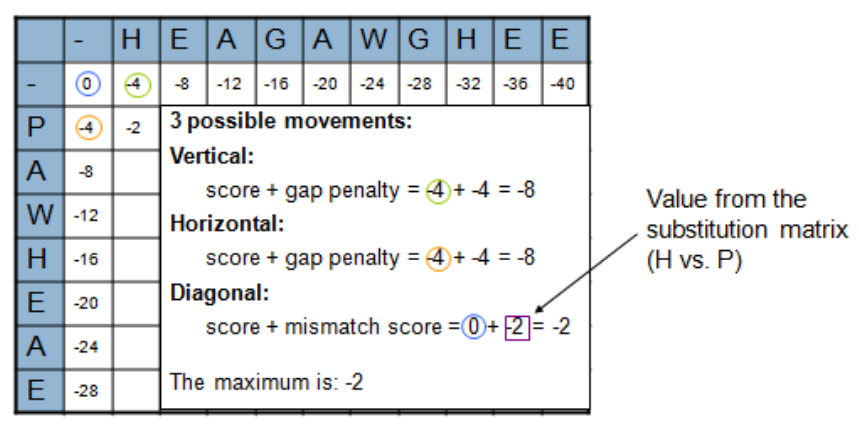

Ezek alapján kiszámoljuk a táblázat értékeit: Minden cellának megnézzük a bal, átlós bal felsó, és felső szomszédos celláinak értékeit (széleken csak az alsókat vagy felsőket), és ezekhez adjuk hozzá a megfelelő értéket. Amikor a bal vagy felső cellát nézzük, akkor mindig a gap penalty-t kell hozzáadni, amikor pedig az átlósat, akkor a match vagy mismatch értéket. Így 3 számot kapunk, és ezek közül a maximális fogja adni az adott cella értékét, és az irányt is, ami szerint majd visszafejtjük az utat.

Az így kiszámolt táblázat jobb alsó sarka fogja az alignment végső pontszámát adni, illetve ebből a sarokból kiindulva megkaphatjuk az "útvonalat" (szekvenciákat), ha a balra, átlósan és a fel irányok közül mindig a legnagyobb értéket választjuk. Amikor bejárjuk az útvonalat, mindig amikor felfele lépünk, akkor gapet illesztünk a horizontális szekvenciába, amikor balra lépünk, gapet illesztünk a vertikális szekvenciába, és amikor átlósan lépünk, akkor csak simán leírjuk a cellához tartozó értékeket.

### Szubsztitúciós mátrix példa: 


# Local alignment - Smith-Waterman

Itt nem ragaszkodunk már az első és utolsó elemek egyezőségéhez. A cél mindössze az, hogy megtaláljuk azt a kis részt a szekvenciák között, ami a legjobban hasonlít bennük.

Ugyanúgy adott 2 szekvencia, amiket egy gap jellel az elejükön táblázatba írunk. Illetve feltöltjük az első sort és első oszlopot 0-kal. A táblázat feltöltése ugyanúgy zajlik mint a global alignmentnél. Amikor minden cella megtelt, meg kell keresni a legnagyobb értékű cellát, és innen keresni vissza az utat, amíg 0-s cellához nem érünk.

In [302]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [303]:
X = "AGGTTGC"
Y = "ACGGTC"

gap = -1
mismatch = -1
match = 1

# Global alignment

In [304]:
def create_global_alignment(X, Y, gap, mismatch, match):
    calc_mat = [[''] * (len(X) + 1)*2 for _ in range((len(Y) + 1)*2)]
    val_mat = np.zeros((len(Y)+1, len(X)+1), int)
    direction_mat = np.zeros((len(Y)+1, len(X)+1), int)
    
    for i in range(0, len(Y)+1):
        for j in range(0, len(X)+1):
            directions = np.array([0, 0, 0]) # left, diag, up
            if (i == 0 and j == 0):
                val_mat[i][j] = 0
                calc_mat[2*i+1][2*j+1] = '0'
                continue
            elif (i == 0):
                val_mat[i][j] = val_mat[i][j-1] + gap
                calc_mat[2*i+1][2*j+1] = val_mat[i][j] 
                continue
            elif (j == 0):
                val_mat[i][j] = val_mat[i-1][j] + gap
                calc_mat[2*i+1][2*j+1] = val_mat[i][j] 
                continue
            else:
                directions[0] = val_mat[i][j-1] + gap
                if (X[j-1] == Y[i-1]):
                    directions[1] = val_mat[i-1][j-1] + match
                else:
                    directions[1] = val_mat[i-1][j-1] + mismatch
                directions[2] = val_mat[i-1][j] + gap
            val_mat[i][j] = np.max(directions)
            direction_mat[i][j] = np.argmax(directions)
            calc_mat[2*i][2*j+1] = directions[2]
            calc_mat[2*i][2*j] = directions[1]
            calc_mat[2*i+1][2*j] = directions[0]
            calc_mat[2*i+1][2*j+1] = val_mat[i][j] 
            
            
    seq1 = ""
    seq2 = ""
    curr = [len(Y)-1, len(X)-1]
    seq1 = X[curr[1]] + seq1 
    seq2 = Y[curr[0]] + seq2 
    while (curr[0] != 0 and curr[1] != 0):
        if (direction_mat[curr[0]][curr[1]] == 0):
            curr[1] -= 1; 
            seq1 = X[curr[1]] + seq1 
            seq2 = "_" + seq2
        elif (direction_mat[curr[0]][curr[1]] == 1):
            curr[0] -= 1;
            curr[1] -= 1;
            seq1 = X[curr[1]] + seq1 
            seq2 = Y[curr[0]] + seq2
        elif (direction_mat[curr[0]][curr[1]] == 2):
            curr[0] -= 1
            seq1 = "_" + seq1 
            seq2 = Y[curr[0]]+ seq2
    return calc_mat, seq1, seq2

### Eredmény:

In [305]:
calc_global, seq1, seq2 = create_global_alignment(X, Y, gap, mismatch, match)
print(seq1)
print(seq2)

A_GGTTGC
ACGGT__C


### Számítás menete:

In [306]:
def plot_calculations(X, Y, data):
    X = "-" + X
    Y = "-" + Y

    column_labels = list(X)
    row_labels = list(Y)

    plt.rcParams["figure.figsize"] = (7, 7) # resize 

    fig, ax = plt.subplots()
    plt.tight_layout()
    plt.margins(0, 0)

    for i in np.arange(0, len(X), 0.5):
        if (i % 1 == 0):
            width = 2
        else:
            width = 0.5
        plt.plot([i, i], [0, len(Y)], linewidth=width, color="k")

    for i in np.arange(0, len(Y), 0.5):
        if (i % 1 == 0):
            width = 2
        else:
            width = 0.5
        plt.plot([0, len(X)],[i, i], linewidth=width, color="k")

    for i in range(0, (len(X))*2):
        for j in range(0, (len(Y))*2):
            if (i%2 == 1 and j%2 == 1):
                fw ='bold'
                fs = 12
            else:
                fw = 'normal'
                fs = 10
            plt.text(i/2+1/4, j/2+1/4, data[j][i], fontsize=fs, horizontalalignment='center',verticalalignment='center', fontweight=fw)

    ax.set_xticks(np.arange(len(X))+0.5)
    ax.set_yticks(np.arange(len(Y))+0.5)
    ax.invert_yaxis()
    ax.xaxis.tick_top()

    ax.set_xticklabels(column_labels)
    ax.set_yticklabels(row_labels)
    plt.show()

In [307]:
plot_calculations(X, Y, calc_global)
# calc_global = pd.DataFrame(calc_global)

# Local alignment

In [308]:
def create_local_alignment(X, Y, gap, mismatch, match):
    calc_mat = [[''] * (len(X) + 1)*2 for _ in range((len(Y) + 1)*2)]
    val_mat = np.zeros((len(Y)+1, len(X)+1), int)
    direction_mat = np.zeros((len(Y)+1, len(X)+1), int)
    
    for i in range(0, len(Y)+1):
        for j in range(0, len(X)+1):
            directions = np.array([0, 0, 0]) # left, diag, up
            if (i == 0 or j == 0):
                val_mat[i][j] = 0
                calc_mat[2*i+1][2*j+1] = '0'
                continue
            else:
                directions[0] = max(val_mat[i][j-1] + gap, 0)
                if (X[j-1] == Y[i-1]):
                    directions[1] = max(val_mat[i-1][j-1] + match, 0)
                else:
                    directions[1] = max(val_mat[i-1][j-1] + mismatch, 0)
                directions[2] = max(val_mat[i-1][j] + gap, 0)
                
            val_mat[i][j] = np.max(directions)
            direction_mat[i][j] = np.argmax(directions)
            calc_mat[2*i][2*j+1] = directions[2]
            calc_mat[2*i][2*j] = directions[1]
            calc_mat[2*i+1][2*j] = directions[0]
            calc_mat[2*i+1][2*j+1] = val_mat[i][j]
            
    seq1 = ""
    seq2 = ""
    ind = np.argmax(val_mat)
    curr = [int((ind/(len(X)+1))) -1, ind%(len(X)+1) -1]
    seq1 = X[curr[1]] + seq1 
    seq2 = Y[curr[0]] + seq2 
    while (val_mat[curr[0]][curr[1]] != 0):
        if (direction_mat[curr[0]][curr[1]] == 0):
            curr[1] -= 1; 
            seq1 = X[curr[1]] + seq1 
            seq2 = "_" + seq2
        elif (direction_mat[curr[0]][curr[1]] == 1):
            curr[0] -= 1;
            curr[1] -= 1;
            seq1 = X[curr[1]] + seq1 
            seq2 = Y[curr[0]] + seq2
        elif (direction_mat[curr[0]][curr[1]] == 2):
            curr[0] -= 1
            seq1 = "_" + seq1 
            seq2 = Y[curr[0]]+ seq2
        
    return calc_mat, seq1, seq2

### Eredmény

In [309]:
calc_local, seq1, seq2 = create_local_alignment(X, Y, gap, mismatch, match) 
print(seq1)
print(seq2)

GGT
GGT


### Számítás menete

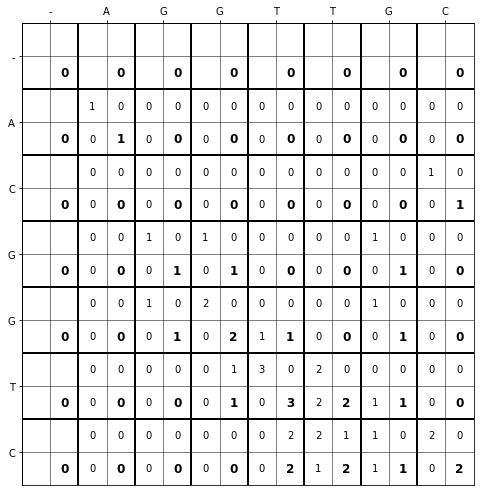

In [310]:
plot_calculations(X, Y, calc_local)